In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import mannwhitneyu, kstest, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from math import sqrt

In [55]:
df = pd.read_csv("../data/processed/filtered_records.csv")
seed = 12250697

## Question 5

In [11]:
# Get difficulties of male and females
difficulty_male = df["average_difficulty"].loc[df["male_gender"] == 1]
difficulty_female = df["average_difficulty"].loc[df["female_gender"] == 1]

# create list for difficulties of all gender combinations
gender_counts = [
    ((df["male_gender"] == 1) & (df["female_gender"] == 0)).sum(),
    ((df["male_gender"] == 0) & (df["female_gender"] == 1)).sum(),
    ((df["male_gender"] == 1) & (df["female_gender"] == 1)).sum(),
    ((df["male_gender"] == 0) & (df["female_gender"] == 0)).sum(),
]

# list of gender categories
gender_categories = [
    "Only Male",
    "Only Female",
    "Both",
    "None"
]

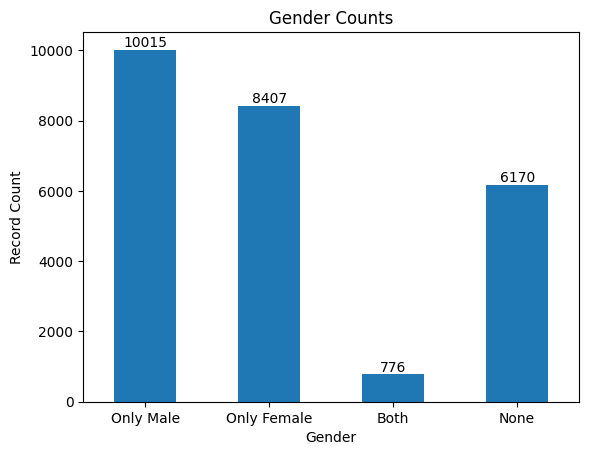

In [12]:
# Plot counts of participant genders
x_values = gender_categories
y_values = gender_counts

df_bars = pd.DataFrame({
        "x": x_values,
        "y": y_values
    })

ax = df_bars.plot(kind="bar", x="x", y="y", legend=False)  # Bar plot
ax.bar_label(ax.containers[0])  # Add value labels on top of each bar
plt.xticks(rotation=-0)  # Keep x tick labels horizontal
plt.title("Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Record Count")
plt.show()

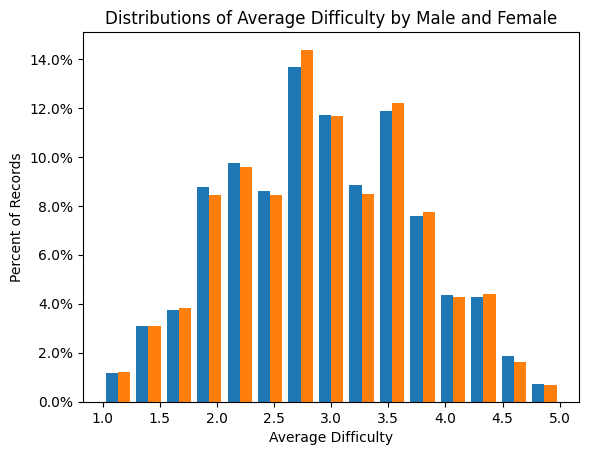

In [13]:
average_difficulty_columns = "average_difficulty"  # Column name for shrek movies
shrek_reviews_female = df[average_difficulty_columns].loc[df["male_gender"] == 1]  # Split into male reviews
shrek_reviews_male = df[average_difficulty_columns].loc[df["female_gender"] == 1]  # Split into female reviews

plt.hist(
    [shrek_reviews_male, shrek_reviews_female],
    bins=15, 
    weights=[
        np.ones(len(shrek_reviews_male)) / len(shrek_reviews_male), 
        np.ones(len(shrek_reviews_female)) / len(shrek_reviews_female)
    ]
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Average Difficulty")
plt.ylabel("Percent of Records")
plt.title("Distributions of Average Difficulty by Male and Female")
plt.show()

In [14]:
U1, p = mannwhitneyu(shrek_reviews_male, shrek_reviews_female)
print(f"U statistic is {U1}")
print(f"p-value is {p}")

U statistic is 49456604.5
p-value is 0.8239822648687855


In [15]:
print(f"Male average difficulty median {shrek_reviews_male.median()}")
print(f"Female average difficulty median {shrek_reviews_female.median()}")

Male average difficulty median 2.9
Female average difficulty median 2.9


In [16]:
ranked_difficulties = df["average_difficulty"].rank(method="average")
ranked_difficulties_male = df["average_difficulty"].loc[df["male_gender"] == 1]
ranked_difficulties_female = df["average_difficulty"].loc[df["female_gender"] == 1]

print(f"Male average rank {ranked_difficulties_male.mean()}")
print(f"Female average rank {ranked_difficulties_female.mean()}")

Male average rank 2.900963766101381
Female average rank 2.899989110312534


## Question 7

In [256]:
def score_model(model, X_train, X_test, y_train, y_test):
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    #r2_score
    train_r2 = r2_score(y_train, y_train_hat)
    test_r2 = r2_score(y_test, y_test_hat)

    #mse
    train_rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_hat))

    out = {
        "Training RMSE": train_rmse,
        "Training R2": train_r2,
        "Testing RMSE": test_rmse,
        "Testing R2": test_r2
    }

    return out

In [120]:
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        13208
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

### Preprocessing

1. Split into training and testing subsets
2. Scale data
3. Fill nulls in would_take_again field using KNN imputation
4. Heatmap to show correlations

In [257]:
# Define training and testing sets
y = df["average_rating"]
X = df[[
    "average_difficulty",
    "number_of_ratings",
    "received_a_pepper",
    "would_take_again",
    "number_of_ratings_online",
    "male_gender",
    "female_gender",
]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Fill in na values via imputation
# would_take_again_median = X_train.median()
# X_train["would_take_again"] = X_train["would_take_again"].fillna(would_take_again_median)
# X_test["would_take_again"] = X_test["would_take_again"].fillna(would_take_again_median)

In [258]:
# Scale data - fit on training data, transform both training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [259]:
# Impute data using k nearest neighbor imputation
imputer = KNNImputer(n_neighbors=10)
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

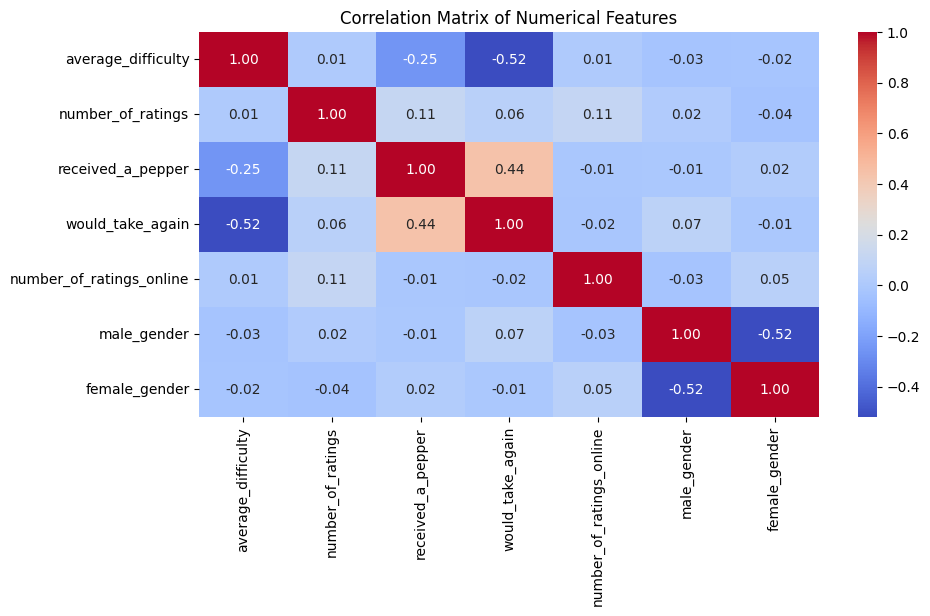

In [260]:
# Correlation matrix
corr = X_train.corr()

# 3. Plot the heatmap using Seaborn
plt.figure(figsize=(10, 5)) # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Simple Linear Regression

In [261]:
# simple linear regression
model = LinearRegression().fit(X_train_scaled, y_train)
simple_linear_model_scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
print(simple_linear_model_scores)

{'Training RMSE': 0.5827966106018181, 'Training R2': 0.6219040362662225, 'Testing RMSE': 0.5951869506417504, 'Testing R2': 0.6016598351966275}


[-0.24186074  0.01559851  0.12857317  0.57353188 -0.00545727  0.02576412
  0.02170311]


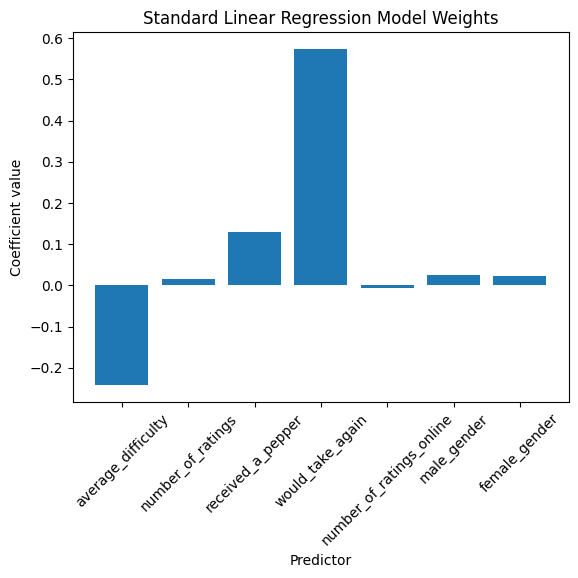

In [262]:
simple_linear_model_coefficients = model.coef_
print(simple_linear_model_coefficients)
plt.bar(X.columns, simple_linear_model_coefficients)
plt.xlabel("Predictor")
plt.ylabel("Coefficient value")
plt.xticks(rotation=45)
plt.title("Standard Linear Regression Model Weights")
plt.show()

 ### Ridge Regression

In [263]:
def alpha_search(alg, alphas):
    rmses = []
    r_squareds = []

    for alpha in alphas:
        # fit model
        model = alg(alpha=alpha, random_state=seed)
        model.fit(X_train_scaled, y_train)

        # Assess model
        scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
        rmses.append(scores["Training RMSE"])
        r_squareds.append(scores["Training R2"])
    
    # Get minimum mean squared error
    minimum_mse = min(rmses)
    minimum_mse_index = rmses.index(minimum_mse)  # index of minimum mean squared error
    best_alpha = alphas[minimum_mse_index]

    # Return output as dictionary
    return {
        "alphas": alphas,
        "training_rmses": rmses,
        "training_r2s": r_squareds,
        "best_alpha": best_alpha,
        "minimum_rmse": minimum_mse
    }


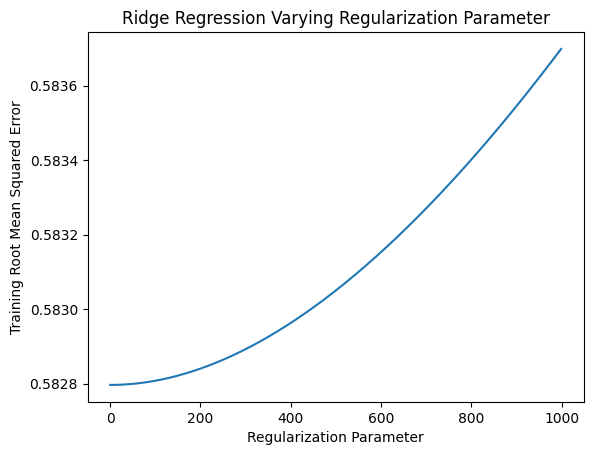

In [264]:
# Ridge regression
alphas = np.arange(0, 1000, 1)
out = alpha_search(Ridge, alphas)

plt.plot(out["alphas"], out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Ridge Regression Varying Regularization Parameter")
plt.show()

### Lasso Regression

/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.446e+03, tolerance: 1.823e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

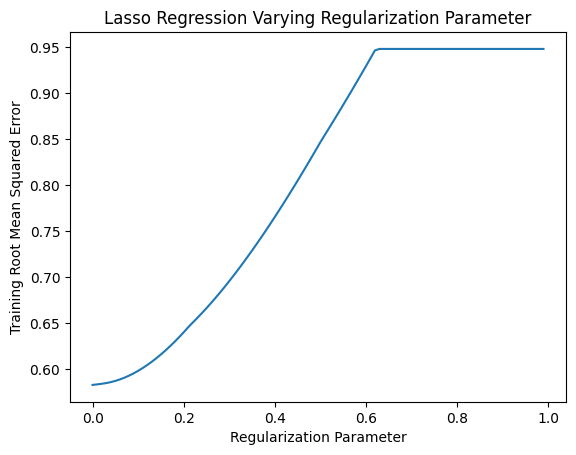

In [265]:
# Lasso regression
alphas = np.arange(0.00, 1, 0.01)
out = alpha_search(Lasso, alphas)

plt.plot(alphas, out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Lasso Regression Varying Regularization Parameter")
plt.show()

## Question 8

### Preprocessing

1. Split into training and testing subsets
2. Scale data to have mean 0 and standard deviation of 1.
3. No nulls, so no need to impute data
4. Correlation plot

In [266]:
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

In [267]:
# Define training and testing sets
y = df["average_rating"]
X = df[df_tags_column_names]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [268]:
# Scale data - fit on training data, transform both training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

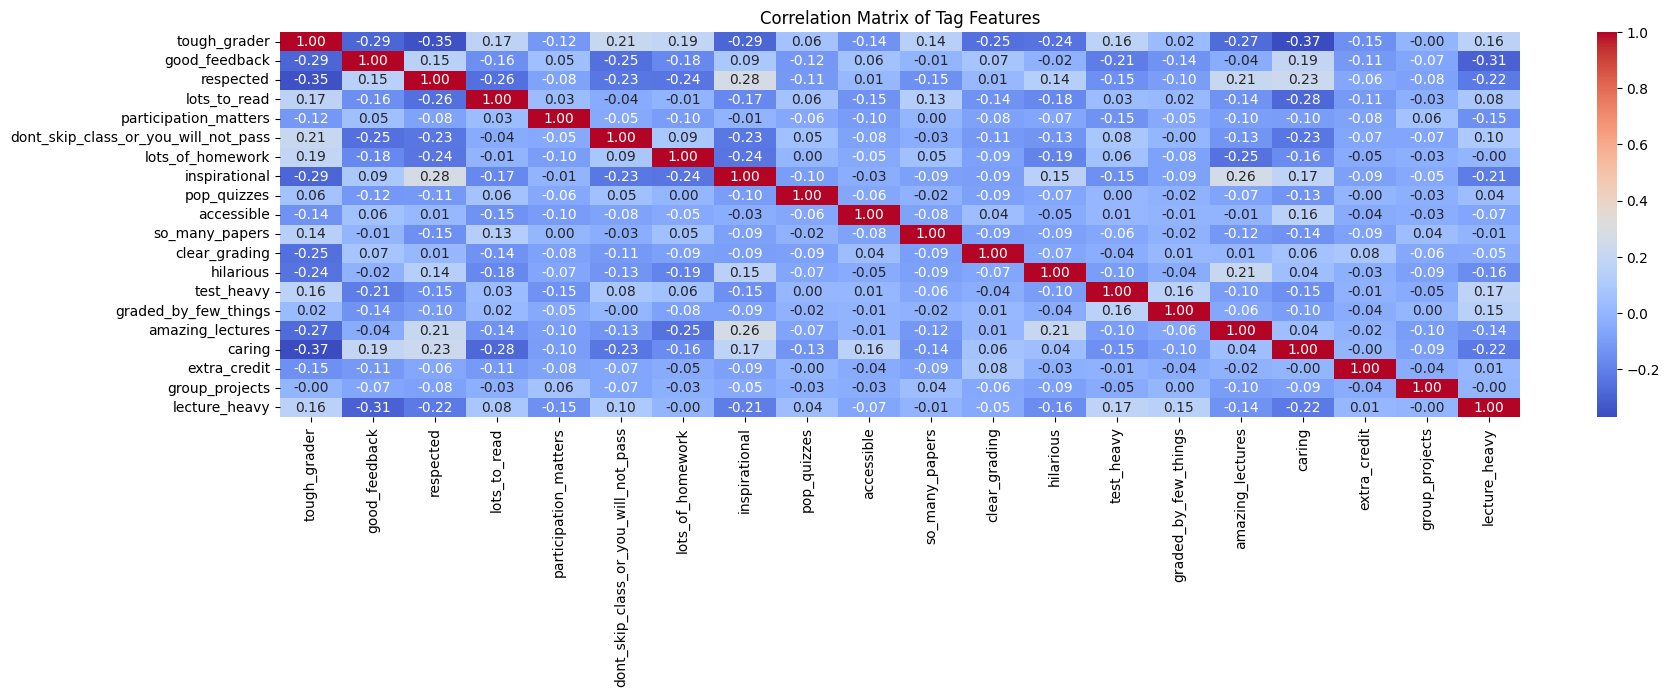

In [269]:
# Correlation matrix
corr = X_train.corr()

# 3. Plot the heatmap using Seaborn
plt.figure(figsize=(20, 5)) # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Tag Features')
plt.show()

### Simple Linear Regression

In [270]:
# simple linear regression
model = LinearRegression().fit(X_train_scaled, y_train)
simple_linear_model_scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
print(simple_linear_model_scores)

{'Training RMSE': 0.5073084685277204, 'Training R2': 0.7135081771925518, 'Testing RMSE': 0.5154148643262388, 'Testing R2': 0.7012821494837158}


[-0.14420925  0.31270779  0.24360265  0.0789572   0.14172583  0.1101547
  0.03274068  0.14859151  0.04550049  0.11052595 -0.01186806  0.18434158
  0.20632929 -0.0145268  -0.01318712  0.2514831   0.23190865  0.16162053
  0.02322572 -0.01598362]


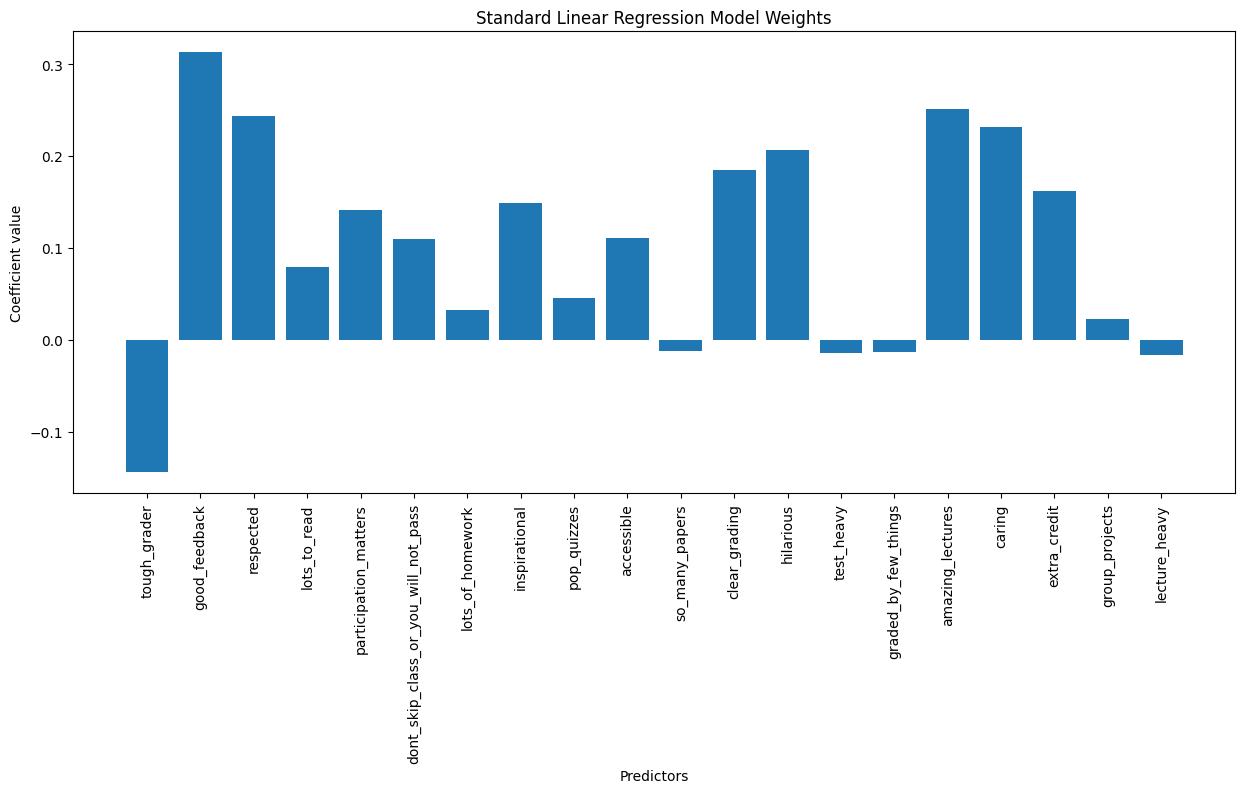

In [271]:
simple_linear_model_coefficients = model.coef_
print(simple_linear_model_coefficients)
plt.figure(figsize=(15, 6))
plt.bar(X.columns, simple_linear_model_coefficients)
plt.xlabel("Predictors")
plt.ylabel("Coefficient value")
plt.xticks(rotation=90)
plt.title("Standard Linear Regression Model Weights")
plt.show()

### Ridge and Lasso Regression are less performant than simple linear regression

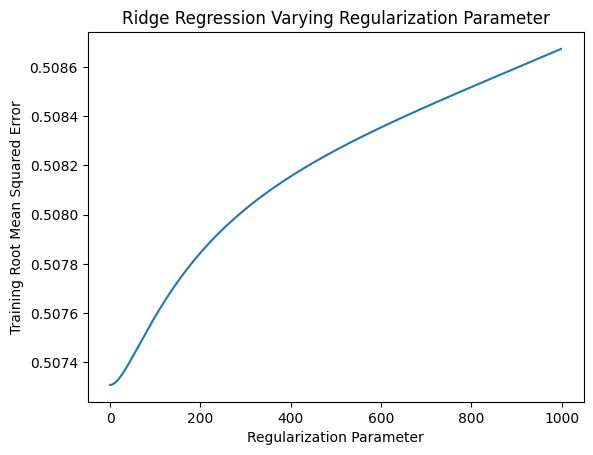

In [272]:
# Ridge regression
alphas = np.arange(0, 1000, 1)
out = alpha_search(Ridge, alphas)

plt.plot(out["alphas"], out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Ridge Regression Varying Regularization Parameter")
plt.show()

/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e+03, tolerance: 1.823e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

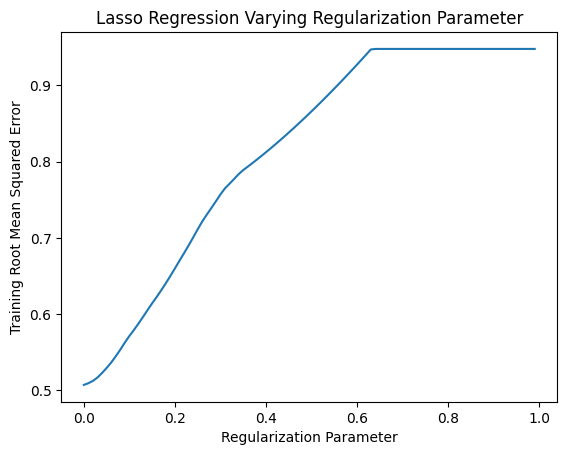

In [273]:
# Lasso regression
alphas = np.arange(0.00, 1, 0.01)
out = alpha_search(Lasso, alphas)

plt.plot(alphas, out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Lasso Regression Varying Regularization Parameter")
plt.show()